In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch.nn.functional as F
import torchvision.models as models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from xgboost import XGBClassifier
import xgboost

In [3]:
# Load CSV data
data_path = 'F:/university/milan/third semester/audio pattern/final/datasets/Data/features_3_sec.csv'
df = pd.read_csv(data_path)
# print(df.head())
# Preprocess the features (assuming each feature column is a flattened version of the spectrogram or wavelet)
X = np.array(df.drop(['filename', 'label'], axis=1))  # Drop non-feature columns
y = np.array(df['label'].values)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction (reduce to 50 components)
pca = PCA(n_components=39)
X_pca = pca.fit_transform(X_scaled)

# Encode the labels (genres)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)   # X_scaled without PCA and X_pca with PCA

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Random forest With PCA fine tuned

Accuracy: 81.28%
Confusion Matrix:
[[170   4   8   2   0  14   4   0   2   4]
 [  0 195   2   0   0   6   0   0   0   0]
 [  9   6 138   7   0   8   1   8   2   7]
 [  3   5   5 154   8   1   3  11   5   4]
 [  2   1   7   5 175   2   4  14   8   0]
 [  7  21   5   1   0 156   0   1   0   1]
 [  2   0   0   1   1   0 190   1   1   8]
 [  1   3   1   5   1   2   0 161   5   1]
 [  5   1   9   7   7   2   0  10 167   3]
 [  5   3  18  16   3   3  13  10   8 118]]
Classification Report:
              precision    recall  f1-score   support

       blues       0.83      0.82      0.83       208
   classical       0.82      0.96      0.88       203
     country       0.72      0.74      0.73       186
       disco       0.78      0.77      0.78       199
      hiphop       0.90      0.80      0.85       218
        jazz       0.80      0.81      0.81       192
       metal       0.88      0.93      0.91       204
         pop       0.75      0.89      0.81       180
      reggae       0.84 

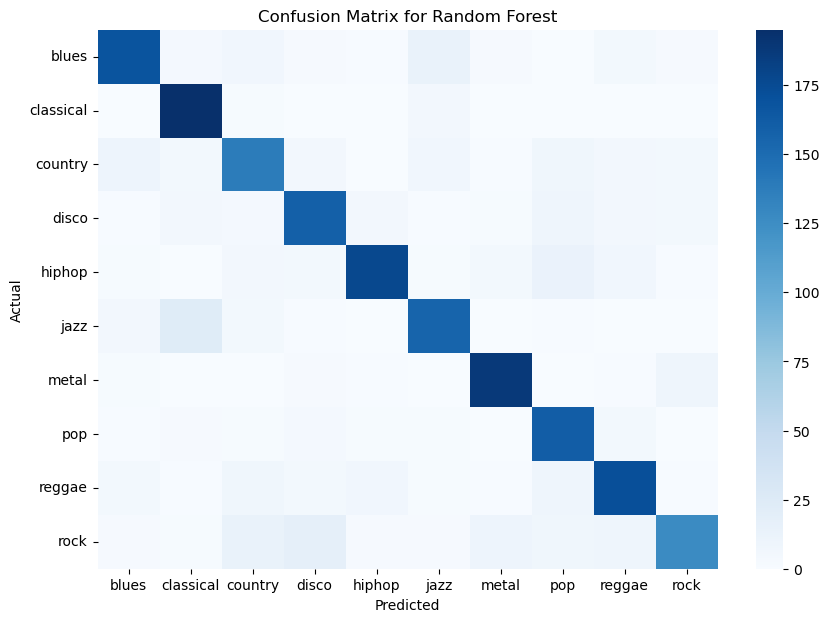

In [10]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the RandomForest model
rf_model.fit(X_train, y_train)

# 2. Predictions and Evaluation
# Predict on test data
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report (includes precision, recall, F1 score)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

# 3. Hyperparameter Tuning
# tune hyperparameters using GridSearchCV to find the best model configuration.

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model from the grid search to make predictions
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Evaluate the tuned model
tuned_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Tuned Accuracy: {tuned_accuracy * 100:.2f}%')

# Confusion Matrix for the tuned model
tuned_conf_matrix = confusion_matrix(y_test, y_pred_best)
print("Tuned Confusion Matrix:")
print(tuned_conf_matrix)

# Classification Report for the tuned model
tuned_class_report = classification_report(y_test, y_pred_best, target_names=label_encoder.classes_)
print("Tuned Classification Report:")
print(tuned_class_report)

# Confusion Matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(tuned_conf_matrix, annot=False, fmt="d", cmap="Blues", xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVM With PCA

spectral_centroid_mean: 1.4638250831357662
chroma_stft_mean: 1.0778969792557618
rms_mean: 0.931197131402627
zero_crossing_rate_var: 0.8962682182453872
mfcc10_mean: 0.8571481933507371
spectral_centroid_var: 0.841367752513901
mfcc5_mean: 0.7960249477477457
spectral_bandwidth_var: 0.7838655658858917
perceptr_mean: 0.7594090249364935
chroma_stft_var: 0.7062150966662362
mfcc1_var: 0.6543672892590445
rolloff_var: 0.651979125786288
length: 0.6457234688540083
zero_crossing_rate_mean: 0.6352762937443766
mfcc7_mean: 0.6323813537851005
mfcc2_var: 0.6316479876434447
mfcc2_mean: 0.6132611044008931
mfcc1_mean: 0.5938931727602015
mfcc10_var: 0.5718564639879472
mfcc9_mean: 0.5604360168346028
mfcc6_mean: 0.5393843147289151
mfcc4_var: 0.5323605407677641
mfcc6_var: 0.44715651736425704
harmony_mean: 0.4320532179052421
tempo: 0.4287929870506353
mfcc11_mean: 0.35786906666600327
mfcc3_var: 0.3095045322479566
rolloff_mean: 0.27287923838108075
mfcc8_mean: 0.22187169466849954
spectral_bandwidth_mean: 0.21835274

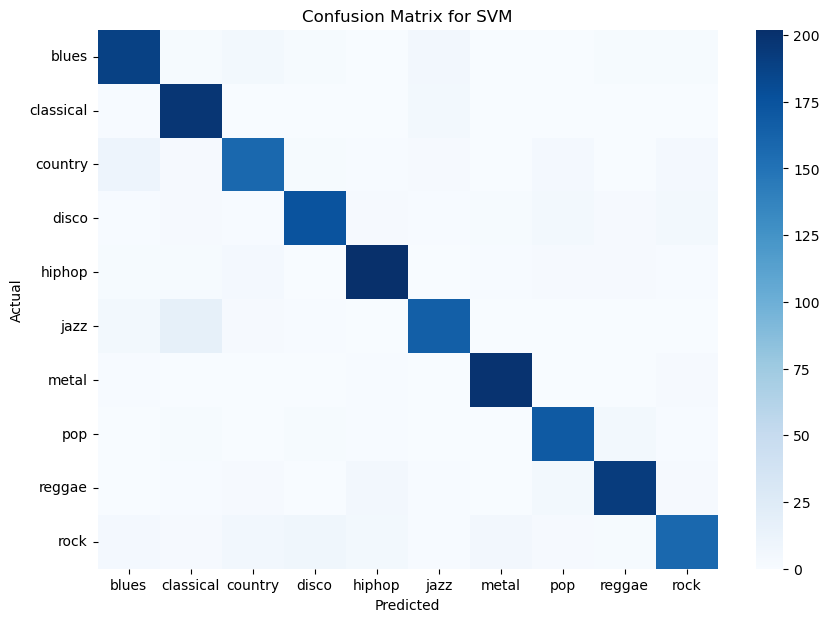

In [9]:
# Initialize SVC
svc_model = SVC(kernel='linear', random_state=42)  # Linear kernel for simplicity

# Train the SVC model
svc_model.fit(X_train, y_train)

# 2. Predictions and Evaluation
# Predict on test data
y_pred = svc_model.predict(X_test)

# SVC does not have a feature_importances_ attribute. Instead, we can use the model's coefficients if it's a linear kernel.
if svc_model.kernel == 'linear':
    feature_importances = np.abs(svc_model.coef_[0])  # Get absolute values of coefficients
else:
    feature_importances = np.zeros(X_train.shape[1])  # No feature importance for non-linear kernels

# Retrieve the column names from the dataframe (which correspond to the features)
feature_names = df.drop(['filename', 'label'], axis=1).columns.tolist()

# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

#print Feature Importance
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {feature_importances[idx]}")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report (includes precision, recall, F1 score)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

# 3. Hyperparameter Tuning (Optional)
# You can tune hyperparameters using GridSearchCV to find the best model configuration.

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model from the grid search to make predictions
best_svc_model = grid_search.best_estimator_
y_pred_best = best_svc_model.predict(X_test)

# Evaluate the tuned model
tuned_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Tuned Accuracy: {tuned_accuracy * 100:.2f}%')

# Confusion Matrix for the tuned model
tuned_conf_matrix = confusion_matrix(y_test, y_pred_best)
print("Tuned Confusion Matrix:")
print(tuned_conf_matrix)

# Classification Report for the tuned model
tuned_class_report = classification_report(y_test, y_pred_best, target_names=label_encoder.classes_)
print("Tuned Classification Report:")
print(tuned_class_report)

# Confusion Matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(tuned_conf_matrix, annot=False, fmt="d", cmap="Blues", xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## XGBoost with PCA

c:\Users\ARASH\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:33:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1200x800 with 0 Axes>

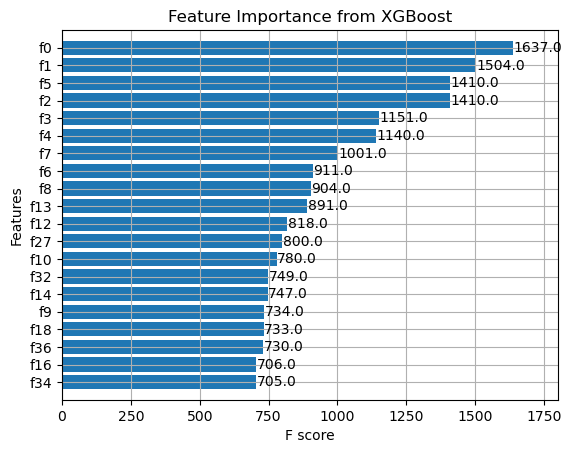

Accuracy: 83.38%
Confusion Matrix:
[[172   2   8   4   0  14   2   0   2   4]
 [  1 191   2   0   0   9   0   0   0   0]
 [ 10   2 146   4   0   6   0   6   2  10]
 [  1   3   7 158   8   0   2   4   5  11]
 [  3   2   6   7 183   0   2   7   6   2]
 [  7  15   5   2   0 159   0   1   1   2]
 [  1   0   0   4   1   0 189   0   0   9]
 [  0   0   1   3   0   0   0 168   4   4]
 [  2   1  10   7  10   3   1   6 166   5]
 [  4   2  14  13   3   2   8   7  10 134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       208
           1       0.88      0.94      0.91       203
           2       0.73      0.78      0.76       186
           3       0.78      0.79      0.79       199
           4       0.89      0.84      0.87       218
           5       0.82      0.83      0.83       192
           6       0.93      0.93      0.93       204
           7       0.84      0.93      0.89       180
           8       0.85 

c:\Users\ARASH\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Tuned Accuracy: 84.63%
Tuned Confusion Matrix:
[[172   1  11   6   0   8   2   0   2   6]
 [  0 189   2   0   0  12   0   0   0   0]
 [  9   2 147   4   1   5   0   8   1   9]
 [  1   5   5 161   5   0   2   5   5  10]
 [  2   2   7   4 188   1   2   4   7   1]
 [  8  14   7   2   0 160   0   0   0   1]
 [  1   0   1   4   0   0 192   0   0   6]
 [  1   0   1   3   2   0   0 167   4   2]
 [  2   1   5   9   8   3   0   5 177   1]
 [  3   2  12  15   3   2   7   8   7 138]]
Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       208
           1       0.88      0.93      0.90       203
           2       0.74      0.79      0.77       186
           3       0.77      0.81      0.79       199
           4       0.91      0.86      0.88       218
           5       0.84      0.83      0.

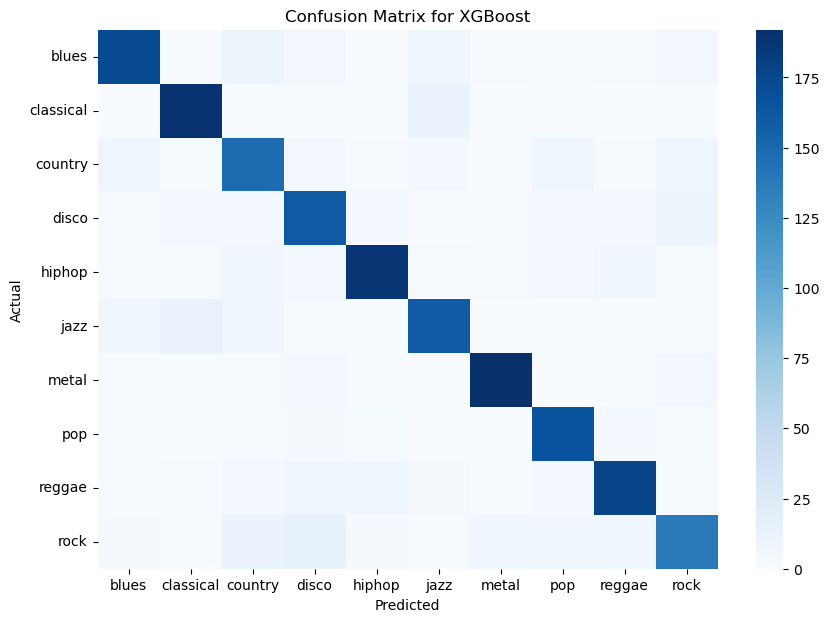

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

# Initialize XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Feature Importance
booster = xgb_model.get_booster()
plt.figure(figsize=(12, 8))
xgb.plot_importance(booster, importance_type='weight', max_num_features=20, height=0.8)
plt.title('Feature Importance from XGBoost')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best model
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)

# Evaluate tuned model
tuned_accuracy = accuracy_score(y_test, y_pred_best)
print(f'Tuned Accuracy: {tuned_accuracy * 100:.2f}%')

# Confusion Matrix for the tuned model
tuned_conf_matrix = confusion_matrix(y_test, y_pred_best)
print("Tuned Confusion Matrix:")
print(tuned_conf_matrix)

# Classification Report for the tuned model
tuned_class_report = classification_report(y_test, y_pred_best)
print("Tuned Classification Report:")
print(tuned_class_report)

# Confusion Matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(tuned_conf_matrix, annot=False, fmt="d", cmap="Blues", xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
